# TP2 - Adrián José Zapater Reig

### Dataset descargado desde
## https://ieee-dataport.org/documents/smart-defender-dataset

La descripción de los campos que componen los datos del dataset están disponible en esa URL

# PARTE 1: Uso de Spark para análisis de datos, Dataframes #

#### Importamos las librerías que vamos a necesitar.

In [1]:
import os
from pyspark.sql import functions as F
import pandas as pd
import matplotlib as plt

In [2]:
# Mostrar la versión de Spark usada
print("Spark Version: " + spark.version)
# Datos de la sesión spark
spark

Spark Version: 2.4.4


In [3]:
# Cargar el dataset en un Dataframe
data_path = os.path.join("data","dataset_descriptor.csv.gz")
cyber_df =  spark.read.option("header","true").csv(data_path)

In [4]:
# Mostrar el schema heredado
cyber_df.printSchema()

root
 |-- ip_proto: string (nullable = true)
 |-- ip_len_mean: string (nullable = true)
 |-- ip_len_median: string (nullable = true)
 |-- ip_len_var: string (nullable = true)
 |-- ip_len_std: string (nullable = true)
 |-- ip_len_entropy: string (nullable = true)
 |-- ip_len_cv: string (nullable = true)
 |-- ip_len_cvq: string (nullable = true)
 |-- ip_len_rte: string (nullable = true)
 |-- ip_ttl_mean: string (nullable = true)
 |-- ip_ttl_median: string (nullable = true)
 |-- ip_ttl_var: string (nullable = true)
 |-- ip_ttl_std: string (nullable = true)
 |-- ip_ttl_entropy: string (nullable = true)
 |-- ip_ttl_cv: string (nullable = true)
 |-- ip_ttl_cvq: string (nullable = true)
 |-- ip_ttl_rte: string (nullable = true)
 |-- sport_mean: string (nullable = true)
 |-- sport_median: string (nullable = true)
 |-- sport_var: string (nullable = true)
 |-- sport_std: string (nullable = true)
 |-- sport_entropy: string (nullable = true)
 |-- sport_cv: string (nullable = true)
 |-- sport_cvq: 

In [5]:
# Mostrar el número de registros del dataset
total_count = cyber_df.count()
total_count

45500

In [6]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
label1_values = cyber_df.select("Label1").distinct().collect()
for label in label1_values:
    print(label.Label1)

http_flood
http_slow_body
tcp_fin_flood
http_slow_range
normal
udp_flood
http_slow_read
tcp_syn_ack_flood
tcp_syn_flood
tcp_ack_flood
http_slow_headers


In [7]:
cyber_df.select("Label1").distinct().count()

11

In [8]:
# Para obtener el mismo resultado que en el PDF debemos usar show(11)
cyber_df.select("Label1").distinct().show(n=11, truncate=False)

+-----------------+
|Label1           |
+-----------------+
|http_flood       |
|http_slow_body   |
|tcp_fin_flood    |
|http_slow_range  |
|normal           |
|udp_flood        |
|http_slow_read   |
|tcp_syn_ack_flood|
|tcp_syn_flood    |
|tcp_ack_flood    |
|http_slow_headers|
+-----------------+



In [9]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
label3_values = cyber_df.select("Label3").distinct().collect()
for label in label3_values:
    print(label.Label3)

http_flood
tcp_flood
normal
udp_flood
http_slow


In [10]:
cyber_df.select("Label3").distinct().count()

5

In [11]:
# Para obtener el mismo resultado que en el PDF podemos usar show(5)
cyber_df.select("Label3").distinct().show(n=5, truncate=False)

+----------+
|Label3    |
+----------+
|http_flood|
|tcp_flood |
|normal    |
|udp_flood |
|http_slow |
+----------+



In [12]:
#Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.
anormal_trafic_count = cyber_df.where(cyber_df.Label3 != F.lit("normal")).count()
anormal_trafic_percentage = (anormal_trafic_count / total_count) * 100
print("% 5.2f %%" % (anormal_trafic_percentage))

 49.26 %


In [13]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico 
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)
trafic_per_label3 = cyber_df.groupBy(cyber_df.Label3).count()
trafic_label3_percentage = trafic_per_label3.select(trafic_per_label3.Label3.alias("traffic"), ((F.col("count") / F.lit(total_count)) * F.lit(100)).alias("percentage"))
trafic_label3_percentage_pd = trafic_label3_percentage.toPandas()
trafic_label3_percentage_pd.plot(kind="bar", x="traffic")

In [14]:
trafic_label3_percentage_pd

,traffic,percentage
0,http_flood,0.762637
1,tcp_flood,32.940659
2,normal,50.742857
3,udp_flood,15.151648
4,http_slow,0.402198


In [15]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir 
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml
traffic_df = cyber_df.withColumn("ip_proto_int", cyber_df.ip_proto * 1000)
traffic_df.select(traffic_df.ip_proto_int).distinct().show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [16]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) 
# de bytes transmitidos agrupados por protocolo
# Usamos F para que python no confunda las funciones de SPARK con las de otros módulos.
traffic_df.groupBy(traffic_df.ip_proto_int).agg(F.sum("ip_len_mean")).show()

+------------+------------------+
|ip_proto_int|  sum(ip_len_mean)|
+------------+------------------+
|        17.0| 7064.346040678179|
|         6.0|26867.191474056726|
+------------+------------------+



In [17]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden de mayor a menor
# NOTA:
# Si se quiere sólo el anómalo, debemos filtrar por Label1 != normal:
anomalous_traffic = cyber_df.where(cyber_df.Label1 != F.lit("normal"))
# Como la solución también incluye el tráfico normal, no filtramos por Label1:
anomalous_traffic = cyber_df
udp_anomalous_traffic = anomalous_traffic.where(anomalous_traffic.ip_proto == F.lit(0.017))
udp_anomalous_traffic_aag = udp_anomalous_traffic.groupBy(udp_anomalous_traffic.Label1).agg(F.sum(udp_anomalous_traffic.ip_len_mean).alias("sum_traffic"))
udp_anomalous_traffic_aag.orderBy(udp_anomalous_traffic_aag.sum_traffic, ascending=False).show()

+---------+------------------+
|   Label1|       sum_traffic|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817847|
+---------+------------------+



In [18]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
# NOTA:
# Si se quiere sólo el anómalo, debemos filtrar por Label1 != normal. Como la solución también incluye el tráfico normal, no filtramos por Label1:
tcp_anomalous_traffic = anomalous_traffic.where(anomalous_traffic.ip_proto == F.lit(0.006))
tcp_anomalous_traffic_aag = tcp_anomalous_traffic.groupBy(tcp_anomalous_traffic.Label1).agg(F.sum(tcp_anomalous_traffic.ip_len_mean).alias("sum_traffic"))
tcp_anomalous_traffic_aag.orderBy(tcp_anomalous_traffic_aag.sum_traffic, ascending=False).show()

+-----------------+------------------+
|           Label1|       sum_traffic|
+-----------------+------------------+
|           normal|11615.053998509044|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268172|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



# PARTE 2: Uso de Spark para análisis de datos, Spark SQL #

Contestar a las cuestiones anteriores empleando Spark SQL

In [19]:
# Crear la vista en memoria y añadir una celda por cada cuestión que se debe responder
cyber_df.createOrReplaceTempView("cyber")

In [20]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
spark.sql("SELECT DISTINCT Label1 FROM cyber").show()

+-----------------+
|           Label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [21]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
spark.sql("SELECT DISTINCT Label3 FROM cyber").show()

+----------+
|    Label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [22]:
#Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.
spark.sql("SELECT CONCAT(ROUND((COUNT(*) / 45500) * 100, 2), ' %') as percentage  FROM cyber WHERE Label1 NOT LIKE 'normal'").show()

+----------+
|percentage|
+----------+
|   49.26 %|
+----------+



In [23]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico 
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)
traffic_percentage = spark.sql("SELECT Label3 as traffic, (COUNT(*) / 45500) * 100 as percentage  FROM cyber GROUP BY Label3")
traffic_percentage.show()

+----------+-------------------+
|   traffic|         percentage|
+----------+-------------------+
|http_flood| 0.7626373626373626|
| tcp_flood|  32.94065934065934|
|    normal|  50.74285714285715|
| udp_flood| 15.151648351648353|
| http_slow|0.40219780219780216|
+----------+-------------------+



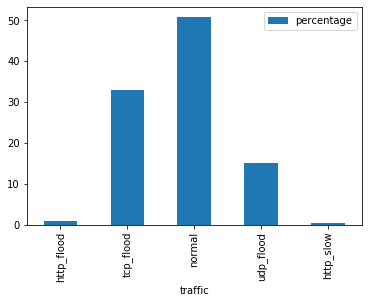

In [24]:
traffic_percentage.toPandas().plot(kind="bar", x="traffic")

In [25]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir 
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml
IANA_cyber = spark.sql("SELECT DISTINCT (ip_proto * 1000) as ip_proto_int FROM cyber")
IANA_cyber.show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [26]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) 
# de bytes transmitidos agrupados por protocolo
spark.sql("SELECT (ip_proto * 1000) as ip_proto_int, SUM(ip_len_mean) FROM cyber GROUP BY ip_proto").show()

+------------+--------------------------------+
|ip_proto_int|sum(CAST(ip_len_mean AS DOUBLE))|
+------------+--------------------------------+
|         6.0|              26867.191474056726|
|        17.0|               7064.346040678179|
+------------+--------------------------------+



In [27]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
spark.sql("SELECT Label1, SUM(ip_len_mean) as sum_ip_len_mean FROM cyber WHERE ip_proto = 0.017 GROUP BY Label1 ORDER BY sum_ip_len_mean DESC").show()

+---------+------------------+
|   Label1|   sum_ip_len_mean|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817847|
+---------+------------------+



In [28]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
spark.sql("SELECT Label1, SUM(ip_len_mean) as sum_ip_len_mean FROM cyber WHERE ip_proto = 0.006 GROUP BY Label1 ORDER BY sum_ip_len_mean DESC").show()

+-----------------+------------------+
|           Label1|   sum_ip_len_mean|
+-----------------+------------------+
|           normal|11615.053998509044|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268172|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



## Conclusiones:
Encuentro interesante la realización de la TP2 con Spark. Me ha gustado realizar los ejercicios con SPARK SQL y con la api de DataFrame para comprobar los retos (y ventajas) que ofrece cada api. </br>

Como mejora propongo un ejercicio:
Cargando un juego de datos de mayor tamaño, ver cómo afecta el data skewness en el rendimiento de SPARK. Para ello se necesitaría un juego de datos mucho mayor y hacer una aoperación JOIN por una clave desbalanceada (valores com muchas repeticiones vs valores con pocas repeticiones). Si ejecutamos el JOIN sin hacer un repartition veremos en el SPARK UI muchas tasks con pocos registros y otras con muchos registros, esto ralentizará el sistema. Si por el contrario hacemos un REPARTITION(N), donde N es un multiplo del número de hilos en el ordenador local, veremos que la carga se reparte y todas las tasks tienen un número similar de registros. La penalización en rendimiento será hacer un SHUFFLE adicional, pero será despreciable cuando el volumen de los datos crezca.